# Refitting NumPyro models with ArviZ

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses `SamplingWrappers` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is one example of `SamplingWrapper` usage for NumPyro.

In [1]:
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax.random as random
from numpyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

In [2]:
numpyro.set_host_device_count(4)

For the example we will use a linear regression.

In [3]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

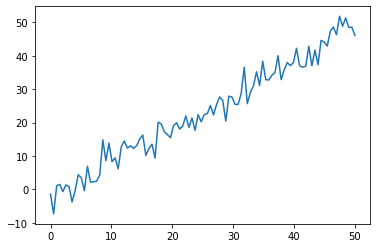

In [4]:
plt.plot(xdata, ydata)

Now we will write the NumPyro code:

In [5]:
def model(N, x, y=None):
    b0 = numpyro.sample("b0", dist.Normal(0, 10))
    b1 = numpyro.sample("b1", dist.Normal(0, 10))
    sigma_e = numpyro.sample("sigma_e", dist.HalfNormal(10))
    numpyro.sample("y", dist.Normal(b0 + b1 * x, sigma_e), obs=y)

In [6]:
data_dict = {
    "N": len(ydata),
    "y": ydata,
    "x": xdata,
}
kernel = NUTS(model)
sample_kwargs = dict(
    sampler=kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4, 
    chain_method="parallel"
)
mcmc = MCMC(**sample_kwargs)
mcmc.run(random.PRNGKey(0), **data_dict)

We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all refits use the same sampler parameters. We follow the same pattern with `az.from_numpyro`.

In [7]:
dims = {"y": ["time"], "x": ["time"]}
idata_kwargs = {
    "dims": dims,
    "constant_data": {"x": xdata}
}
idata = az.from_numpyro(mcmc, **idata_kwargs)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

We will create a subclass of `az.SamplingWrapper`. Therefore, instead of having to implement all functions required by `az.reloo` we only have to implement `sel_observations` (we are cloning `sample` and `get_inference_data` from the `PyStanSamplingWrapper` in order to use `apply_ufunc` instead of assuming the log likelihood is calculated within Stan). 

Note that of the 2 outputs of `sel_observations`, `data__i` is a dictionary because it is an argument of `sample` which will pass it as is to `model.sampling`, whereas `data_ex` is a list because it is an argument to `log_likelihood__i` which will pass it as `*data_ex` to  `apply_ufunc`. More on `data_ex` and `apply_ufunc` integration below.

In [8]:
class NumPyroSamplingWrapper(az.SamplingWrapper):
    def __init__(self, model, **kwargs):        
        self.model_fun = model.sampler.model
        self.rng_key = kwargs.pop("rng_key", random.PRNGKey(0))
        
        super(NumPyroSamplingWrapper, self).__init__(model, **kwargs)
        
    def log_likelihood__i(self, excluded_obs, idata__i):
        samples = {
            key: values.values.reshape((-1, *values.values.shape[2:]))
            for key, values 
            in idata__i.posterior.items()
        }
        log_likelihood_dict = numpyro.infer.log_likelihood(
            self.model_fun, samples, **excluded_obs
        )
        if len(log_likelihood_dict) > 1:
            raise ValueError("multiple likelihoods found")
        data = {}
        nchains = idata__i.posterior.dims["chain"]
        ndraws = idata__i.posterior.dims["draw"]
        for obs_name, log_like in log_likelihood_dict.items():
            shape = (nchains, ndraws) + log_like.shape[1:]
            data[obs_name] = np.reshape(log_like.copy(), shape)
        return az.dict_to_dataset(data)[obs_name]
    
    def sample(self, modified_observed_data):
        self.rng_key, subkey = random.split(self.rng_key)
        mcmc = MCMC(**self.sample_kwargs)
        mcmc.run(subkey, **modified_observed_data)
        return mcmc

    def get_inference_data(self, fit):
        # Cloned from PyStanSamplingWrapper.
        idata = az.from_numpyro(mcmc, **self.idata_kwargs)
        return idata
    
class LinRegWrapper(NumPyroSamplingWrapper):
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"].values
        ydata = self.idata_orig.observed_data["y"].values
        mask = np.isin(np.arange(len(xdata)), idx)
        data__i = {"x": xdata[~mask], "y": ydata[~mask], "N": len(ydata[~mask])}
        data_ex = {"x": xdata[mask], "y": ydata[mask], "N": len(ydata[mask])}
        return data__i, data_ex

In [9]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using Pareto Smoothed Importance Sampling (PSIS) works for all observations, so we will use modify `loo_orig` in order to make `az.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [10]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper. Let's stop and analize each of the arguments. 

We use `idata_orig` as a starting point, and mostly as a source of observed and constant data which is then subsetted in `sel_observations`.

We also use `model` to get automatic log likelihood computation and we have the option to set the `rng_key`. Even if the data for each fit is different the `rng_key` is splitted with every fit.

Finally, `sample_kwargs` and `idata_kwargs` are used to make sure all refits and corresponding InferenceData are generated with the same properties.

In [11]:
numpyro_wrapper = LinRegWrapper(
    mcmc, 
    rng_key=random.PRNGKey(5),
    idata_orig=idata, 
    sample_kwargs=sample_kwargs, 
    idata_kwargs=idata_kwargs
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [12]:
loo_relooed = az.reloo(numpyro_wrapper, loo_orig=loo_orig)

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 13
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 13
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 42
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 42
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 56
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 56
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 73
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 73


In [13]:
loo_relooed

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.89     7.20
p_loo        3.08        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%